In [1]:
from PIL import Image
from use_existingmodels import test_depth_model, test_pose_model
from matplotlib import pyplot as plt
from kitti_utils import (
    compute_image_from_velodyne_matrices, load_lidar_points,
    get_camera_intrinsic_dict, get_relative_pose
)
from overlay_lidar_utils import (
     generate_lidar_point_coord_camera_image, plot_lidar_on_image, plot_point_hue_on_image
)
from compute_photometric_error_utils import (
    color_target_points_with_source, project_points_on_image, filter_to_plane, filter_to_fov,
    reproject_source_to_target, plot_sparse_img_and_surrounding_lidar,
    calc_photo_error_velo
)
import os
import numpy as np

-> Loading model from  models\mono_640x192
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on 1 test images
-> Done!


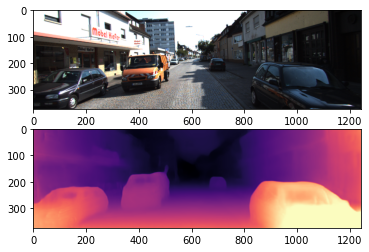

In [2]:
test_depth_model('data/kitti_example/2011_09_26/2011_09_26_drive_0048_sync/image_02/data/0000000000.png', 'mono_640x192', output_path='data', display_result = True, no_filesave = True)

In [3]:
# Path names
calib_path = "data/kitti_example/2011_09_26"
scene_path = os.path.join(calib_path, "2011_09_26_drive_0048_sync")

RGB_MAX_DIST = np.sqrt(3) * 255

# Set target and source for display
target = 11
source = 21

# Get transformation matrices
velo2cam = compute_image_from_velodyne_matrices(calib_path)["stereo_left"]
rel_pose = test_pose_model(os.path.join(scene_path, f"image_02/data/{target:010}.png"),os.path.join(scene_path, f"image_03/data/{source:010}.png"),  'mono_640x192')
print(rel_pose)
# Set velodyne points
target_velodyne = load_lidar_points(os.path.join(scene_path, f"velodyne_points/data/{target:010}.bin"))
orig_colors = np.copy(target_velodyne[:, 3])
target_velodyne[:, 3] = 1

# Read in image files
img_tgt = np.array(Image.open(os.path.join(scene_path, f"image_02/data/{target:010}.png")))
img_src = np.array(Image.open(os.path.join(scene_path, f"image_02/data/{source:010}.png")))

-> Loading model from  models\mono_640x192
   Loading pretrained encoder
   Loading pretrained decoder
-> Predicting on relative pose for test images
-> Done!
[[ 9.9998242e-01  3.4093489e-03 -4.8562610e-03  1.1284857e-03]
 [-3.4076907e-03  9.9999416e-01  3.5010034e-04 -1.6973284e-04]
 [ 4.8574251e-03 -3.3356401e-04  9.9998814e-01 -3.6581848e-02]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]


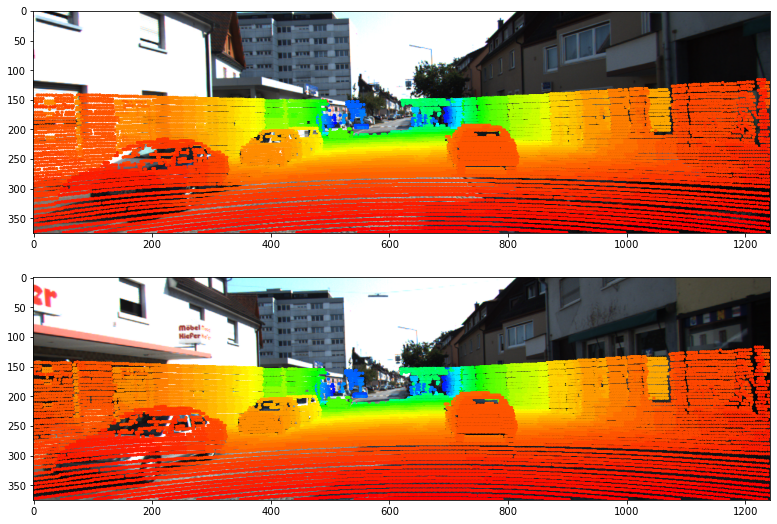

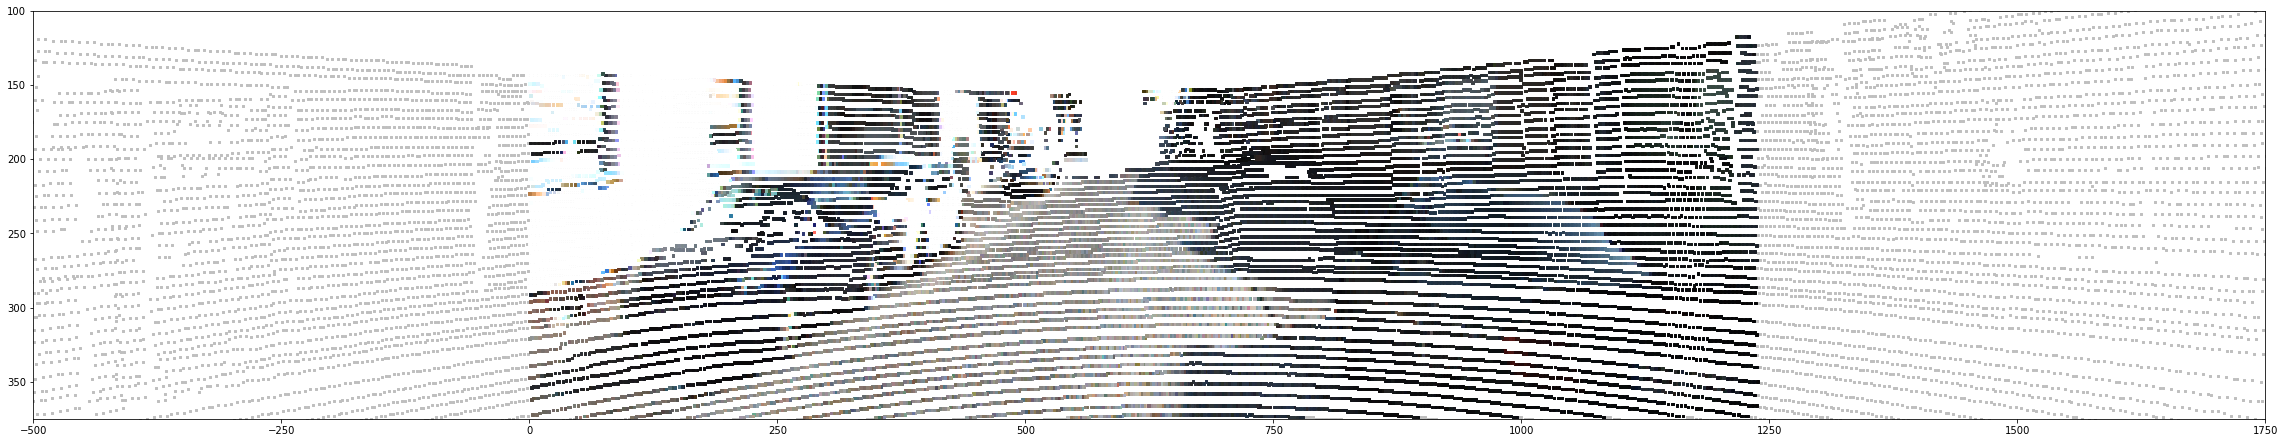

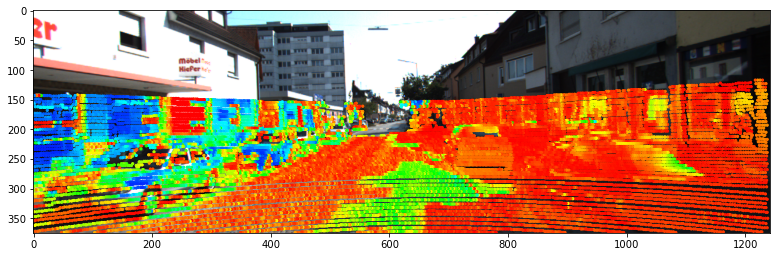

In [4]:
# Transform velodyne points into target and source camera planes
transform_to_src = target_velodyne @ rel_pose.T
src_coord = filter_to_fov(filter_to_plane(project_points_on_image(transform_to_src, velo2cam)), img_src.shape)
tgt_coord = filter_to_fov(filter_to_plane(project_points_on_image(target_velodyne, velo2cam)), img_tgt.shape)

# Plot lidar points on each image
fig = plt.figure(figsize=(32, 9))
plot_lidar_on_image(img_src, src_coord, fig, 1)
plot_lidar_on_image(img_tgt, tgt_coord, fig, 2)

# Project source lidar points (with color from source image) into target frame
color_points, point_tgt_frame = color_target_points_with_source(target_velodyne, img_src, velo2cam, rel_pose)
plot_sparse_img_and_surrounding_lidar(point_tgt_frame, color_points[:, :4], color_points[:, 4:] / 255)

# Calculate photometric error for each velodyne point and plot on target image (blue is more error)
fig = plt.figure(figsize=(32, 9))
errors = calc_photo_error_velo(img_tgt, color_points) / RGB_MAX_DIST
plot_point_hue_on_image(img_tgt, color_points, errors, fig, 1)